<a href="https://colab.research.google.com/github/praveentn/MidcurveNN/blob/master/cnn_encdec/notebook_cnn_autoencoder_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN ENC-DEC

In [1]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,AveragePooling2D,UpSampling2D
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# working directory
wdir = os.getcwd()
wdir

'/content/gdrive/My Drive/Colab Notebooks/MidcurveNN'

In [4]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
input_data_folder = wdir + "/data/images"
print("input data dir: ", input_data_folder)

input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images


In [5]:
import glob

image_paths = glob.glob(input_data_folder + '/**/*.png', recursive=True)
images = [os.path.basename(img_path) for img_path in image_paths]

print(len(images))

#images = os.listdir(input_data_folder)
images[99]

4032


'CapI_Midcurve_mirrored_0_translated_10_-20.png'

In [0]:
# image dimension
imdim = 100

In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
def get_training_data(datafolder=input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [9]:
shapes = os.listdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images')
shapes

['CapI',
 'Plus',
 'Iuvw',
 'Luvw',
 'SqLu',
 'Tuvw',
 'Vuvw',
 'Sm_n',
 'InvV',
 'Parl',
 'Trap',
 'Stik',
 'Usla',
 'LapT',
 'RelY',
 'T002',
 'T003',
 'T004']

In [10]:
profile_pngs_objs = ()
midcurve_pngs_objs = ()

for shape in shapes:
    print(shape)
    tp, tm = get_training_data(os.path.join(input_data_folder, shape))
    profile_pngs_objs += tp
    midcurve_pngs_objs += tm
    print(len(profile_pngs_objs), len(midcurve_pngs_objs))

CapI
112 112
Plus
224 224
Iuvw
336 336
Luvw
448 448
SqLu
560 560
Tuvw
672 672
Vuvw
784 784
Sm_n
896 896
InvV
1008 1008
Parl
1120 1120
Trap
1232 1232
Stik
1344 1344
Usla
1456 1456
LapT
1568 1568
RelY
1680 1680
T002
1792 1792
T003
1904 1904
T004
2016 2016


In [11]:
len(profile_pngs_objs)

2016

In [12]:
profile_pngs_objs[0].shape

(100, 100)

In [13]:
type(midcurve_pngs_objs)

tuple

In [0]:
def plot_results(original_imgs,computed_imgs,n=10):
    # n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(imdim, imdim),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

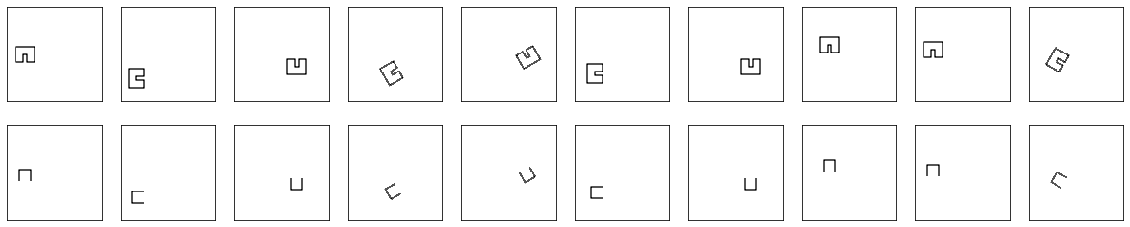

In [15]:
plot_results(profile_pngs_objs[830:850],midcurve_pngs_objs[830:850])

In [0]:
def get_train_test_split(profile_pngs_gray_objs, midcurve_pngs_gray_objs, encoding_dim=imdim, input_dim=imdim):

    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    '''
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    '''
    x_train, x_test, y_train, y_test = train_test_split(profile_pngs_objs, midcurve_pngs_objs, 
                                                        test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [18]:
x_train, x_test, y_train, y_test = get_train_test_split(profile_pngs_objs, midcurve_pngs_objs)

print((len(x_train), len(y_train)), (len(x_test), len(y_test)))

(1612, 1612) (404, 404)


### Auto-encoder

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = imdim
        self.img_cols = imdim
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        #optimizer = Adam(lr=0.0005)
        optimizer = SGD(lr=0.0002, decay=0.0001, nesterov=True)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

W0819 14:46:52.305503 140134280529792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 14:46:52.306696 140134280529792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 14:46:52.316228 140134280529792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 14:46:52.350270 140134280529792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 14:46:52.403425 140134280529792 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 32)        0         
__________

W0819 14:46:52.698703 140134280529792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1612 samples, validate on 404 samples
Epoch 1/50
1612/1612 [==============================] - 7s 4ms/step - loss: -8.9238 - val_loss: -9.1666
Epoch 2/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.6551 - val_loss: -9.1801
Epoch 3/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.6710 - val_loss: -9.1933
Epoch 4/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.6852 - val_loss: -9.2060
Epoch 5/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.6988 - val_loss: -9.2182
Epoch 6/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.7121 - val_loss: -9.2300
Epoch 7/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.7249 - val_loss: -9.2422
Epoch 8/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.7376 - val_loss: -9.2537
Epoch 9/50
1612/1612 [==============================] - 3s 2ms/step - loss: -9.7491 - val_loss: -9.2655
Epoch 10/50
1612/

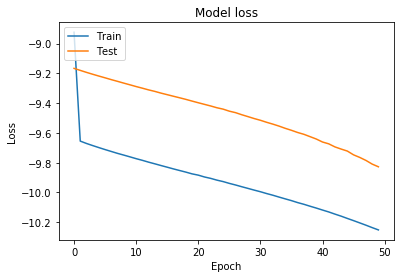

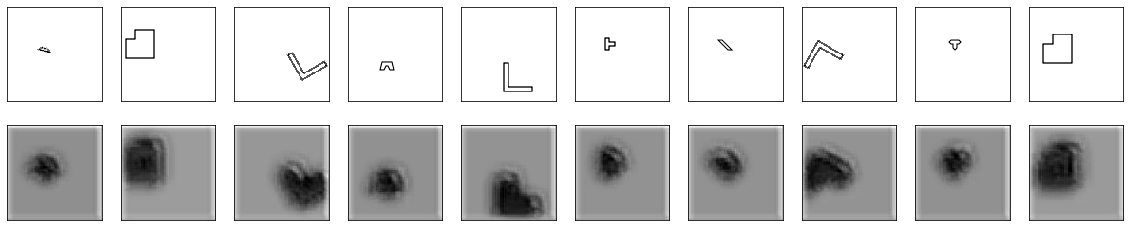

In [20]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_test, y_test, epochs=50, batch_size=50)

encoded_imgs = ae.eval_model(x_test)
decoded_imgs = ae.eval_model(encoded_imgs)

plot_results(x_test, decoded_imgs)

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = imdim
        self.img_cols = imdim
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.0005)
        optimizer = SGD(lr=0.0001, nesterov=False)
        
        self.autoencoder_model = self.build_model()
        #self.autoencoder_model.compile(loss='mean_squared_error', optimizer=RMSprop())
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        #x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        #x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        #x = MaxPooling2D((2, 2), padding='same')(x)
        #encoded = MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is compressed

        #x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        #x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        #x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        #x = UpSampling2D((2, 2))(x)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        
        '''
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer) #28 x 28 x 32
        h = MaxPooling2D(pool_size=(2, 2))(h) #14 x 14 x 32
        #h = Conv2D(64, (3, 3), activation='relu', padding='same')(h) #14 x 14 x 64
        #h = MaxPooling2D(pool_size=(2, 2))(h) #7 x 7 x 64
        #h = Conv2D(128, (3, 3), activation='relu', padding='same')(h) #7 x 7 x 128 (small and thick)

        #decoder
        #h = Conv2D(128, (3, 3), activation='relu', padding='same')(h) #7 x 7 x 128
        #h = UpSampling2D((2,2))(h) # 14 x 14 x 128
        #h = Conv2D(64, (3, 3), activation='relu', padding='same')(h) # 14 x 14 x 64
        #h = UpSampling2D((2,2))(h) # 28 x 28 x 64
        h = Conv2D(32, (3, 3), activation='relu', padding='same')(h) # 14 x 14 x 64
        h = UpSampling2D((2,2))(h) # 28 x 28 x 64
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h) # 28 x 28 x 1
        '''
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 16)      4624      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 64)      18496     
__________

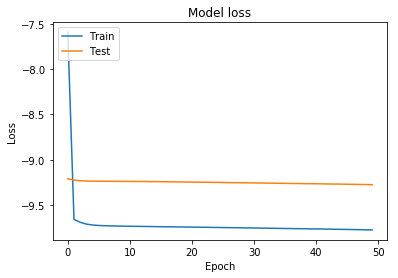

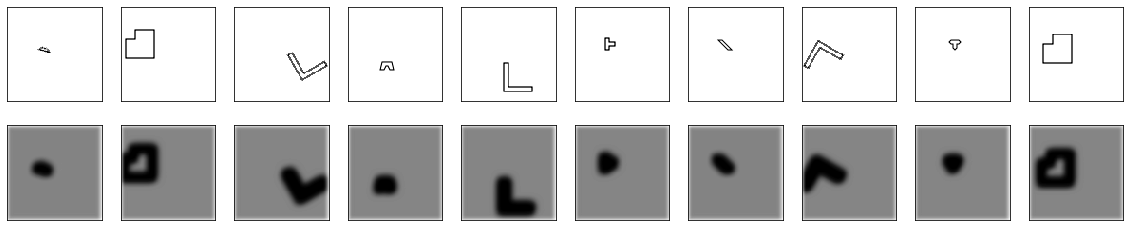

In [22]:
'''
x_train_reshaped = x_train
x_test_reshaped = x_test


noise_factor = 0.01 
x_train_noisy = x_train_reshaped + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_reshaped.shape) 
x_test_noisy = x_test_reshaped + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_reshaped.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
'''

ae = Autoencoder()
#ae.train_model(x_train_noisy, y_train, x_test_noisy, y_test, epochs=50, batch_size=32)
ae.train_model(x_train, y_train, x_test, y_test, epochs=50, batch_size=64)

encoded_imgs = ae.eval_model(x_test)
decoded_imgs = ae.eval_model(encoded_imgs)

plot_results(x_test, decoded_imgs)